# Taxi Classification

For this task, you will explore NYC January 2019 taxi data available on NYC Open data.
We've already completed data import and cleaning steps, so you can focus on training and interpreting your model. 

The taxi data set is extensive, and includes a row for every Yellow and Green cab ride in the city.
We're interested to see how you can use the features of that data (distance, speed, tolls, passengers, time, duration, etc) to *classify* records by geography - namely, a model that predicts the starting and ending borough based on the features of the ride. 

If we used the full data set, this would be a 25 class prediction problem - interesting, but too complex for what we're trying to accomplish in this interview task.
So we're limiting the scope of the data to two kinds of trips.

* Manhattan -> Queens
* Manhattan -> Brooklyn 

Your model should use the features of a ride to predict the likelihood that a given ride is Manhattan -> Queens or Manhattan -> Brooklyn.
After you've made your model, we're interested in how well it did for some dropoff neighborhoods.
Choose one neighborhood where your model performed well, one where it performed worse than random, and one where its performance is near-random.
Put together some analysis (within this notebook is fine!) for these neighborhoods.
Discuss the performance of your model for these neighborhoods and any ideas about why it performed the way it did. 
Note the goal is not to train the model to maximize performance in these neighborhoods, but rather to dig in and understand any underperformances.

# Packages

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# Data Ingestion

In [ ]:
#read taxi data surrounding January 2019 yellow and green trips, as well as taxi location zones
df = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv')
zones = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv')

In [ ]:
print(df.shape)
print(zones.shape)

(7667792, 18)
(265, 4)


### Data Cleaning

In [ ]:
#cleaner column names
df.columns = ['VendorID', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge']

In [ ]:
#limit zone file to location and borough 
zones = zones[['LocationID', 'Borough', 'Zone']]

#get the pick up and drop off borough info 
df = df.merge(zones, left_on='PULocationID', right_on='LocationID', how='inner')
df = df.merge(zones, left_on='DOLocationID', right_on='LocationID', how='inner')

#create new column for borough combinations and drop columns not needed 
df['borough_combo'] = df['Borough_x'] + '_' + df['Borough_y']
# rename pick up and drop off zone columns for clarity
df.rename(columns={'Zone_y':'Zone_dropoff'}, inplace=True)

df = df.drop(['PULocationID', 'DOLocationID', 'LocationID_x', 'LocationID_y', 'Borough_x', 'Borough_y', 'Zone_x', 'RatecodeID', 'congestion_surcharge'], axis=1)

combo1 = df['borough_combo'] == 'Manhattan_Queens'
combo2 = df['borough_combo'] =='Manhattan_Brooklyn'
df_subset = df[combo1 | combo2].copy()

df_subset['borough_combo'].value_counts()

Manhattan_Queens      200825
Manhattan_Brooklyn    173238
Name: borough_combo, dtype: int64

In [ ]:
df_subset

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Zone_dropoff,borough_combo
4088782,1,2019-01-01 00:42:45,2019-01-01 01:18:45,2,8.70,N,1,31.00,0.5,0.5,8.05,0.00,0.3,40.35,Jackson Heights,Manhattan_Queens
4088783,2,2019-01-01 14:52:35,2019-01-01 15:19:00,1,8.89,N,2,29.50,0.0,0.5,0.00,5.76,0.3,36.06,Jackson Heights,Manhattan_Queens
4088784,2,2019-01-03 00:07:34,2019-01-03 00:30:08,1,7.65,N,2,25.00,0.5,0.5,0.00,5.76,0.3,32.06,Jackson Heights,Manhattan_Queens
4088785,2,2019-01-03 22:37:02,2019-01-03 23:05:58,2,11.27,N,1,34.00,0.5,0.5,0.04,5.76,0.3,41.10,Jackson Heights,Manhattan_Queens
4088786,2,2019-01-05 16:27:42,2019-01-05 16:59:39,1,7.66,N,2,28.00,0.0,0.5,0.00,5.76,0.3,34.56,Jackson Heights,Manhattan_Queens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7667783,2,2019-01-14 17:31:11,2019-01-14 18:56:11,2,20.21,N,1,70.00,1.0,0.5,0.00,2.16,0.3,73.96,Broad Channel,Manhattan_Queens
7667784,2,2019-01-24 23:00:29,2019-01-24 23:49:47,1,16.98,N,1,52.50,0.5,0.5,13.45,0.00,0.3,67.25,Broad Channel,Manhattan_Queens
7667785,2,2019-01-21 18:29:10,2019-01-21 19:20:33,1,17.86,N,1,54.92,0.0,0.5,0.00,0.00,0.3,55.72,Broad Channel,Manhattan_Queens
7667786,2,2019-01-27 01:04:55,2019-01-27 01:49:41,1,23.34,N,1,65.00,0.5,0.5,0.00,5.76,0.3,72.06,Broad Channel,Manhattan_Queens


In [ ]:
#change time columns to datetime 
df_subset.pickup_datetime = pd.to_datetime(df_subset.pickup_datetime)
df_subset.dropoff_datetime = pd.to_datetime(df_subset.dropoff_datetime)

#limit values to logical ones
df_subset = df_subset[df_subset['fare_amount']>0]
df_subset = df_subset[df_subset['tip_amount']>=0]
df_subset = df_subset[df_subset['extra']>=0]
df_subset = df_subset[df_subset['total_amount']<500]
df_subset = df_subset[df_subset['trip_distance']<40]
df_subset = df_subset[df_subset['trip_distance']>0]

In [ ]:
df_subset.shape
df_subset['borough_combo'].value_counts()


Manhattan_Queens      200580
Manhattan_Brooklyn    173116
Name: borough_combo, dtype: int64

In [ ]:
df_subset

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Zone_dropoff,borough_combo
4088782,1,2019-01-01 00:42:45,2019-01-01 01:18:45,2,8.70,N,1,31.00,0.5,0.5,8.05,0.00,0.3,40.35,Jackson Heights,Manhattan_Queens
4088783,2,2019-01-01 14:52:35,2019-01-01 15:19:00,1,8.89,N,2,29.50,0.0,0.5,0.00,5.76,0.3,36.06,Jackson Heights,Manhattan_Queens
4088784,2,2019-01-03 00:07:34,2019-01-03 00:30:08,1,7.65,N,2,25.00,0.5,0.5,0.00,5.76,0.3,32.06,Jackson Heights,Manhattan_Queens
4088785,2,2019-01-03 22:37:02,2019-01-03 23:05:58,2,11.27,N,1,34.00,0.5,0.5,0.04,5.76,0.3,41.10,Jackson Heights,Manhattan_Queens
4088786,2,2019-01-05 16:27:42,2019-01-05 16:59:39,1,7.66,N,2,28.00,0.0,0.5,0.00,5.76,0.3,34.56,Jackson Heights,Manhattan_Queens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7667783,2,2019-01-14 17:31:11,2019-01-14 18:56:11,2,20.21,N,1,70.00,1.0,0.5,0.00,2.16,0.3,73.96,Broad Channel,Manhattan_Queens
7667784,2,2019-01-24 23:00:29,2019-01-24 23:49:47,1,16.98,N,1,52.50,0.5,0.5,13.45,0.00,0.3,67.25,Broad Channel,Manhattan_Queens
7667785,2,2019-01-21 18:29:10,2019-01-21 19:20:33,1,17.86,N,1,54.92,0.0,0.5,0.00,0.00,0.3,55.72,Broad Channel,Manhattan_Queens
7667786,2,2019-01-27 01:04:55,2019-01-27 01:49:41,1,23.34,N,1,65.00,0.5,0.5,0.00,5.76,0.3,72.06,Broad Channel,Manhattan_Queens


### EDA

Show us the visualizations and additional data digging you would want to complete before jumping into modeling. 

#Broad Summary and Visualizations

We see that our dataset contain no null values or duplicates and that the majority of our columns are numeric. However looking at the names and describe summary, we suspect that some of these are better off recoded as categorical or binary, such as **VendorID** or **payment_type**.

In [ ]:
#Basic look at nulls, duplicates, and numerical summary
print('Any duplicates?:', any(df_subset.duplicated()))
df_subset.info()
df_subset.describe()

Any duplicates?: False
<class 'pandas.core.frame.DataFrame'>
Int64Index: 373696 entries, 4088782 to 7667787
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               373696 non-null  int64         
 1   pickup_datetime        373696 non-null  datetime64[ns]
 2   dropoff_datetime       373696 non-null  datetime64[ns]
 3   passenger_count        373696 non-null  int64         
 4   trip_distance          373696 non-null  float64       
 5   store_and_fwd_flag     373696 non-null  object        
 6   payment_type           373696 non-null  int64         
 7   fare_amount            373696 non-null  float64       
 8   extra                  373696 non-null  float64       
 9   mta_tax                373696 non-null  float64       
 10  tip_amount             373696 non-null  float64       
 11  tolls_amount           373696 non-null  float64       
 12  improvement_su

,VendorID,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,373696.000000,373696.000000,373696.000000,373696.000000,373696.000000,373696.000000,373696.000000,373696.000000,373696.000000,373696.000000,373696.000000
mean,1.659558,1.579321,8.519636,1.254233,28.131813,0.426015,0.497498,4.093205,1.944583,0.299975,35.403553
std,0.532401,1.229321,4.887425,0.453887,12.900499,0.647818,0.035281,4.000257,2.782701,0.002732,16.517773
min,1.000000,0.000000,0.010000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310000
25%,1.000000,1.000000,4.710000,1.000000,18.000000,0.000000,0.500000,0.000000,0.000000,0.300000,22.300000
50%,2.000000,1.000000,7.360000,1.000000,25.500000,0.500000,0.500000,3.720000,0.000000,0.300000,31.560000
75%,2.000000,2.000000,10.750000,1.000000,34.500000,0.500000,0.500000,6.450000,5.760000,0.300000,45.070000
max,4.000000,7.000000,39.820000,4.000000,200.000000,5.300000,0.500000,212.000000,101.550000,0.300000,258.560000


We look at a pairplot and a correlation heatmap to get a high level view of what values our variables take to inform us on any additional recoding or relationships. Some observations that I have.


*   **VendorID**, **payment_type**, **mta_tax**, **improvement_surcharge** only takes a few distinct values and maybe should not be numeric.
*   Many of our columns are linearly related and we may need to cull some for the sake of avoiding multicollinearity and redundancy. For example, **trip_distance, fare_amount, tip_amount** and **total_amount** are all correlated and common sense backs this up.



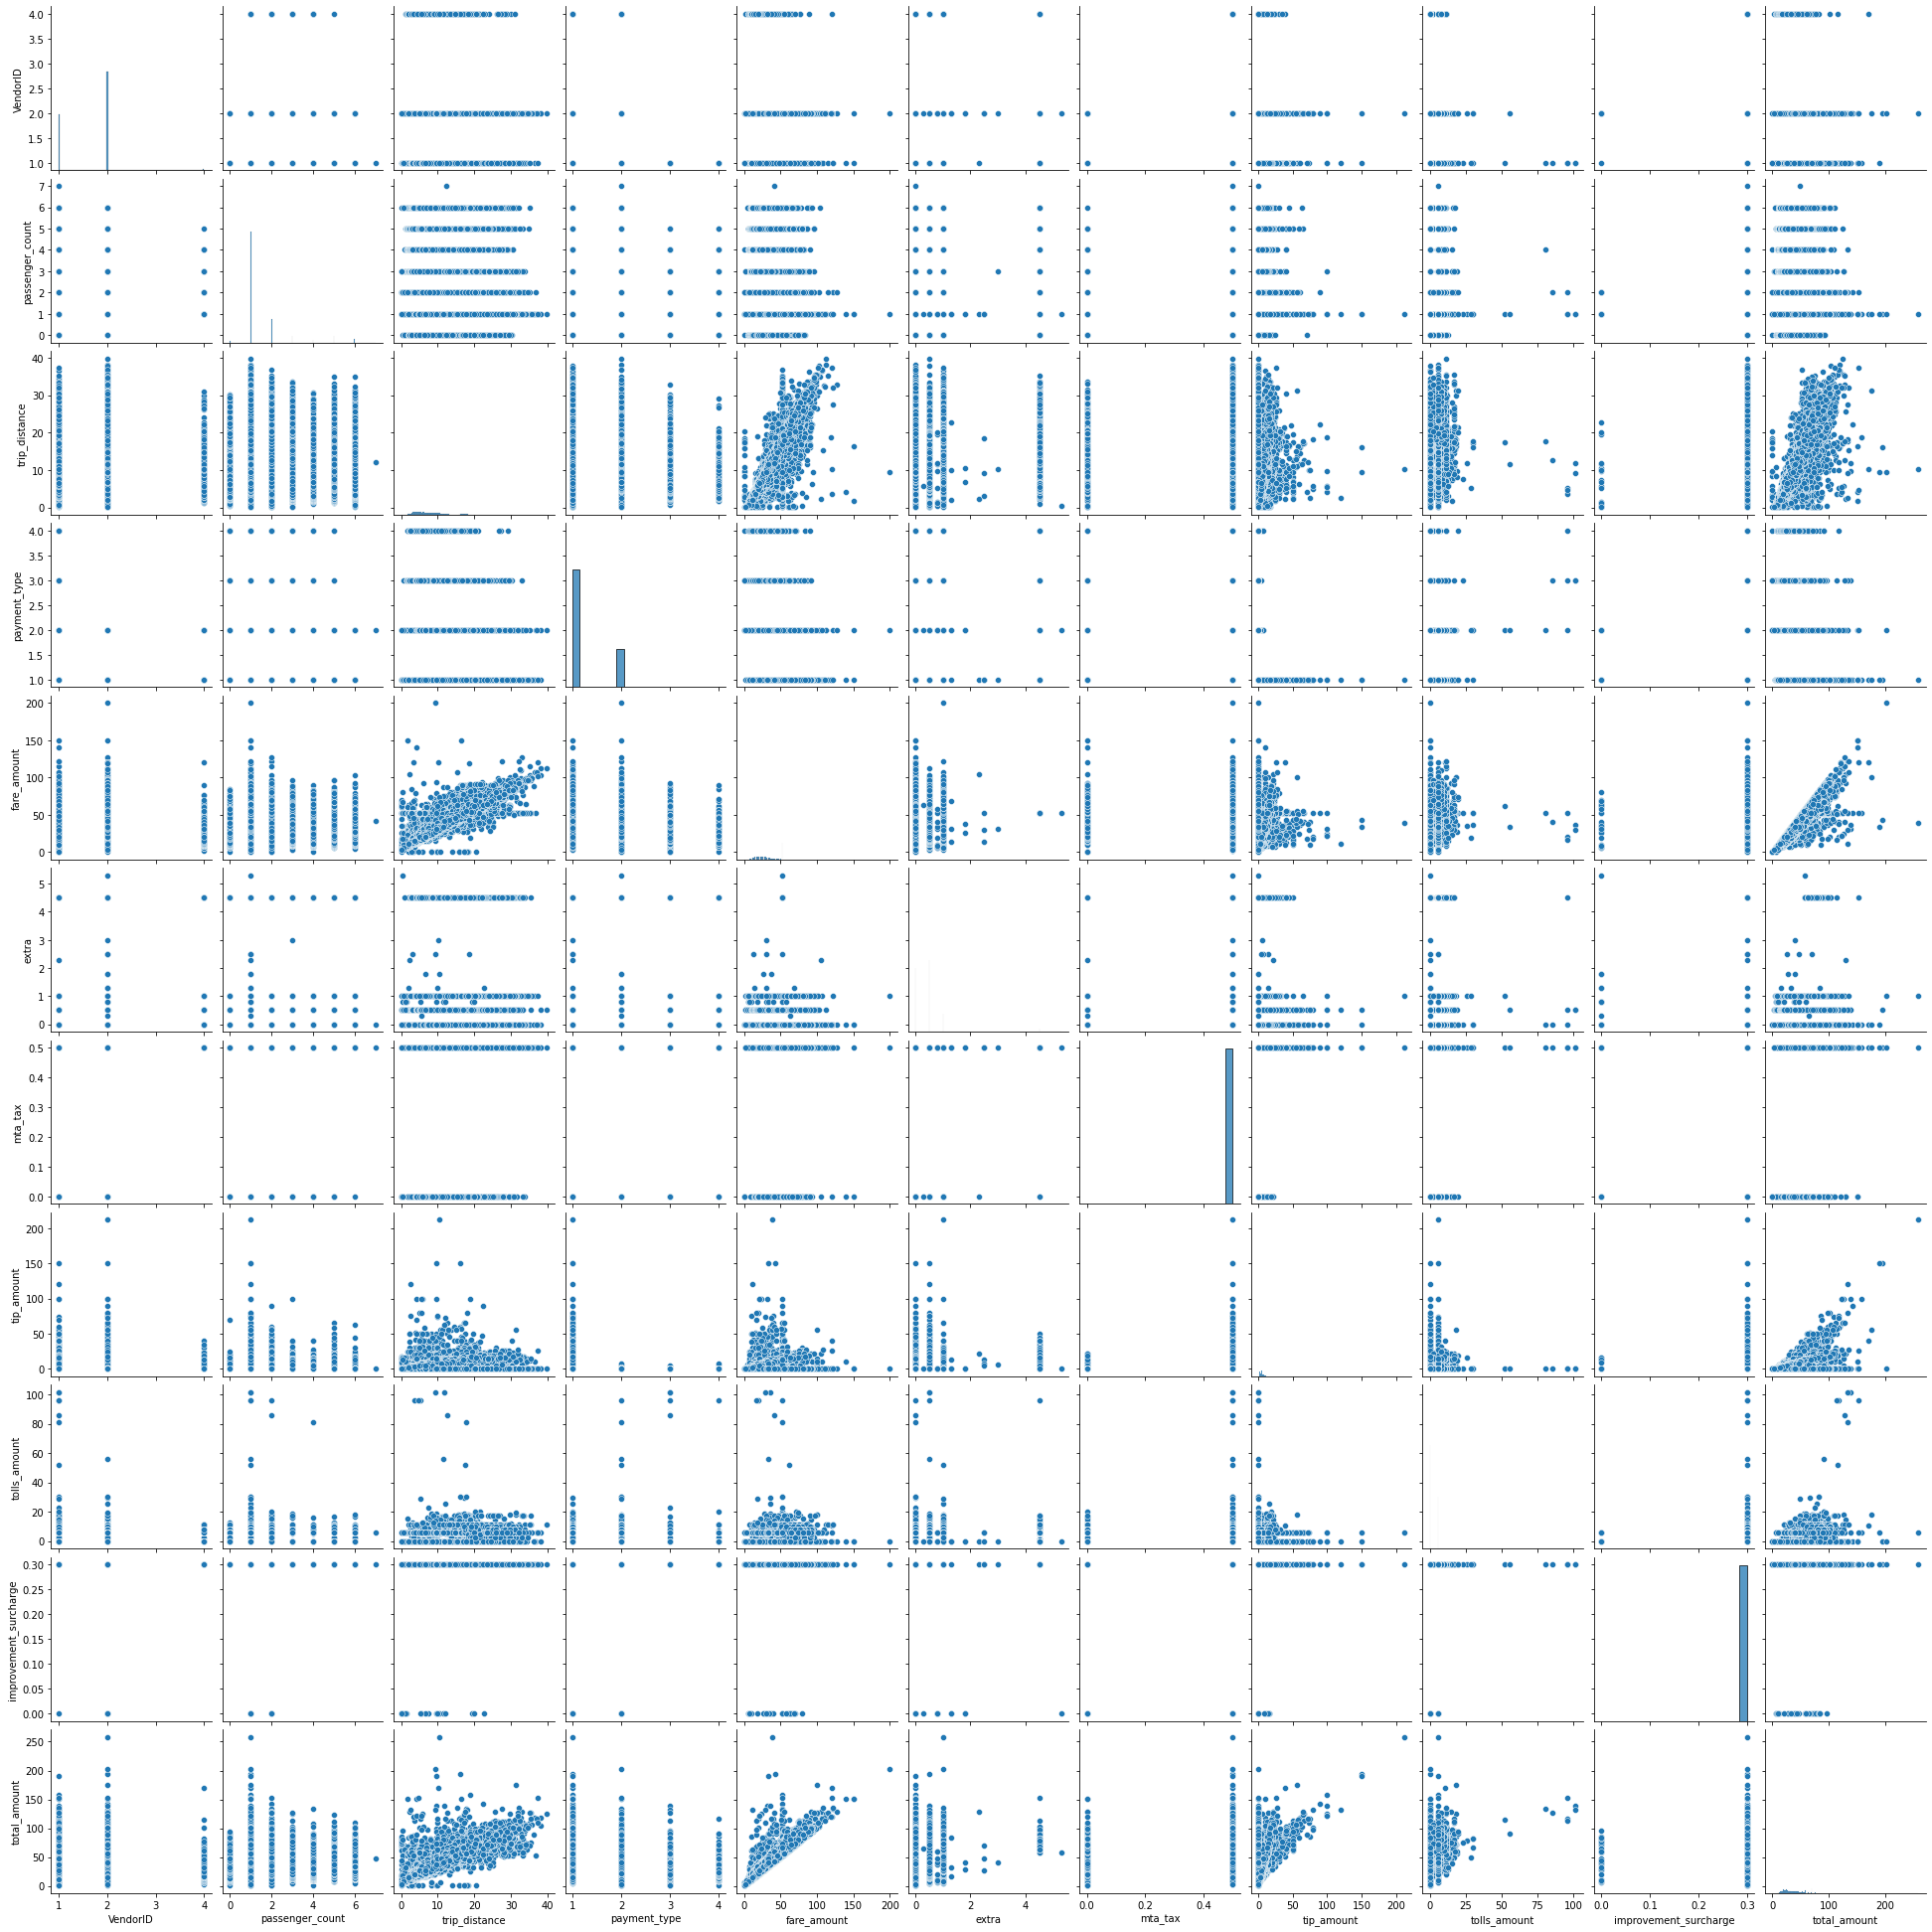

In [ ]:
sns.pairplot(df_subset)

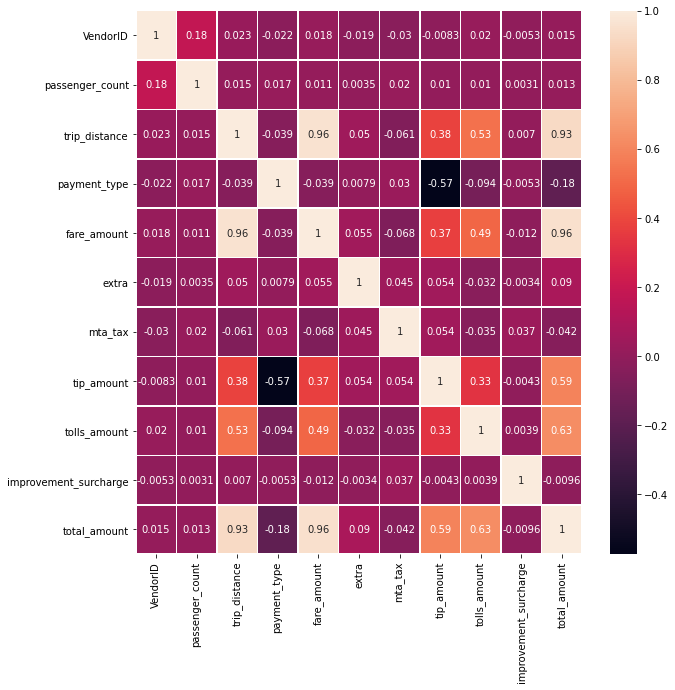

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))      
sns.heatmap(data=df_subset.corr(), annot=True, linewidths=.5, ax=ax)

#Understanding the variables we're working with
To better understand what information the variables cover, I reference the [Yellow](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf) and [Green](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf) taxi data dictionaries from the NYC gov site.

I explore value counts for these variables to understand their nature and to determine which, if any, values should be collapsed into a category. 

I also create an indicator variable **Queens** with 1 representing *Manhattan_Queens* and 0 for *Manhattan_Brooklyn* for easier bivariate analysis.

In [ ]:
#Creating Queens as an indicator variable for when a ride ends in Queens. Otherwise Brooklyn. 
df_subset_modified = df_subset
def Queens(row):
    if (row['borough_combo'] == 'Manhattan_Queens'):
        return 1 
    else:
        return 0

df_subset_modified['Queens'] = df_subset_modified.apply(Queens, axis=1)

#Creating mean Queens variable for a red horizontal reference lines in charts. 
Queens_mean = df_subset_modified.Queens.mean()

#VendorID

From the data dictionary, there are mainly two values, 1= *Creative Mobile Technologies, LLC*; 2= *VeriFone Inc*. There appears to also be a minor third **VendorID** not in the dictionary which we can recode as *Other*. This is clearly better suited as a categorical variable rather than numerical.

In [ ]:
df_subset_modified.VendorID.value_counts(normalize=True)

2    0.630103
1    0.360079
4    0.009818
Name: VendorID, dtype: float64

In [ ]:
#Changing VendorID to a categorical variable
def VendorID(row):
    if row['VendorID'] == 1:
        return 'CMT'
    elif row['VendorID'] == 2:
        return 'Verifone' 
    else:
        return 'Other'

df_subset_modified['VendorID'] = df_subset_modified.apply(VendorID, axis=1)

The bar plot doesn't indicate differences between any **VendorID** and the proportion of rides going to **Queens**. 

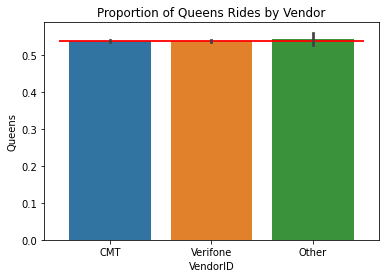

In [ ]:
#Creating Barplot split by VendorID, including 95% Confidence intervals
VendorID_chart = sns.barplot(x="VendorID", y="Queens", data=df_subset_modified, ci=95)
VendorID_chart.axes.set_title("Proportion of Queens Rides by Vendor")
VendorID_chart.axes.hlines(y = Queens_mean, color='red', linewidth=2, alpha=.9, xmin = -0.5, xmax = 2.5)

#Payment_type

Of the 6 values listed the data dictionary, we see that our dataset contains 1 = *Credit Card*, 2 = *Cash*, 3 = *No Charge*, and 4 = *Dispute* with the *Credit Card* and *Cash* comprising >99% of our observations. 

In [ ]:
df_subset_modified.payment_type.value_counts(normalize=True)

1    0.752577
2    0.242010
3    0.004017
4    0.001397
Name: payment_type, dtype: float64

From a bar plot we, also find that both 95% Confidence Intervals for *No Charge* and *Dispute* contain the dataset mean for **Queens** rides. Thus I believe we can combine *No Charge* and *Dispute* as *Other*, and create categorical variables with *Card*, *Cash* and *Other*. 

Additionally, given that our red reference line is contained in neither *Card* nor *Cash*, this may indicate that differentiating between payment types could yield some insight in predicting **Queens**; namely appears that *Cash* payments are more likely to be rides to *Queens* and *Card* to *Brooklyn*.

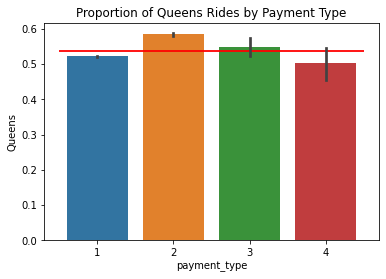

In [ ]:
#Creating Barplot split by payment type, including 95% Confidence intervals
payment_chart = sns.barplot(x="payment_type", y="Queens", data=df_subset_modified, ci=95)
payment_chart.axes.set_title("Proportion of Queens Rides by Payment Type")
payment_chart.axes.hlines(y = Queens_mean, color='red', linewidth=2, alpha=.9, xmin = -0.5, xmax = 3.5)

In [ ]:
#Changing payment_type to a categorical variable
def payment_type(row):
    if row['payment_type'] == 1:
        return 'Card'
    elif row['payment_type'] == 2:
        return 'Cash' 
    else:
        return 'Other'

df_subset_modified['payment_type'] = df_subset_modified.apply(payment_type, axis=1)

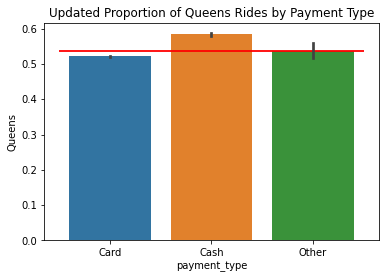

In [ ]:
#Creating Barplot split by updated payment type
payment_chart2 = sns.barplot(x="payment_type", y="Queens", data=df_subset_modified, ci=95)
payment_chart2.axes.set_title("Updated Proportion of Queens Rides by Payment Type")
payment_chart2.axes.hlines(y = Queens_mean, color='red', linewidth=2, alpha=.9, xmin = -0.5, xmax = 2.5)

#MTA_tax

From the data dictionary and [an independent taxi intelligence site](https://cbcny.org/research/taxis-taxes-and-mta-funding-gap#:~:text=6-,Per%2DRide%20Tax,on%20metered%20rides%20as%20well.), the **mta_tax** is a *50c* tax automatically levied upon rides starting and ending in NYC which this dataset ostensibly is completely comprised of. The value counts indicate that >99% observations results in the tax.

A breakdown by *payment_type* indicates that only *Other* results in a rate of **mta_tax** being levied under 99% which makes me suspect that the *0.0* values for **mta_tax** are results of logistical errors which may be more likely for disputed or uncharged rides. 

Based on this, I believe that this the **mta_tax** is unlikely to be a useful predictor.

In [ ]:
df_subset_modified.mta_tax.value_counts(normalize=True)

0.5    0.994996
0.0    0.005004
Name: mta_tax, dtype: float64

In [ ]:
# Creating groupby and getting percents for each.
payment_mta = df_subset_modified.groupby(['payment_type','mta_tax']).size()
payment_mta_pct = payment_mta.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
payment_mta_pct

payment_type  mta_tax
Card          0.0         0.630789
              0.5        99.369211
Cash          0.0         0.081824
              0.5        99.918176
Other         0.0         1.087494
              0.5        98.912506
dtype: float64

In [ ]:
df_subset_modified.groupby('mta_tax').mean()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,Queens
mta_tax,,,,,,,,,
0.0,1.235294,12.696829,40.470524,0.018235,1.031540,3.311743,0.298556,45.132684,0.490374
0.5,1.581051,8.498628,28.069759,0.428066,4.108603,1.937707,0.299982,35.354623,0.536980


In [ ]:
#Dropping the mta_tax column
df_subset_modified.drop('mta_tax', axis = 1, inplace=True)

#Improvement_surcharge
The dictionary defines **improvement_surcharge** as a *30c* charge levied starting 2015 for the purpose of improving wheelchair accessibility. From the value counts, we see that >99.99% of the data includes this charge. 

Of the 31 rides without such a charge, it seems like most of them are going to Queens, specifically 14 of the 31 rides to JFK. Given the low data count, it's possible that this is a logistical issue, such as an individual driver whose usual route includes JFK forgetting to levy this charge. 

Thus given our prior knowledge and the sheer rarity of not levying the **improvement_surcharge**, we believe this is safe to exclude.

In [ ]:
df_subset_modified.improvement_surcharge.value_counts(normalize=True)

0.3    0.999917
0.0    0.000083
Name: improvement_surcharge, dtype: float64

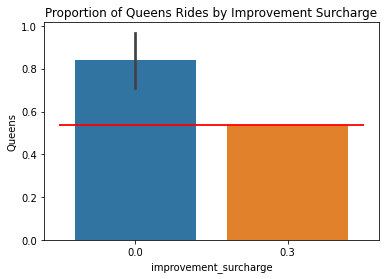

In [ ]:
#Creating Barplot split by improvement_surcharge
improvement_barplot = sns.barplot(x="improvement_surcharge", y="Queens", data=df_subset_modified, ci=95)
improvement_barplot.axes.set_title("Proportion of Queens Rides by Improvement Surcharge")
improvement_barplot.axes.hlines(y = Queens_mean, color='red', linewidth=2, alpha=.9, xmin = -0.5, xmax = 1.5)

In [ ]:
df_subset_modified[df_subset_modified.improvement_surcharge == 0.0].Zone_dropoff.value_counts()

JFK Airport                       14
Long Island City/Hunters Point     3
LaGuardia Airport                  2
Sunnyside                          2
South Ozone Park                   1
Fort Greene                        1
Flushing                           1
Astoria                            1
Crown Heights North                1
Bay Ridge                          1
Long Island City/Queens Plaza      1
Park Slope                         1
East Williamsburg                  1
Richmond Hill                      1
Name: Zone_dropoff, dtype: int64

In [ ]:
#Dropping the improvement_surcharge column
df_subset_modified.drop('improvement_surcharge', axis = 1, inplace=True)

#Extra
Dictionary defines as miscellaneous extras and surcharges including the *50c* rush hour and *1*$ overnight. 

Over 99.99% of the data falls into *0.5, 0.0, 1.0*, and *4.5* and upon plotting, we find that *4.5* charges almost always go to Queens, *0.5* and *1.0* both behave similarly more to Brooklyn, and *0.0* more to Queens. I believe it would be prudent to treat **extra** as categorical in the form of ranges.

In [ ]:
df_subset_modified.extra.value_counts(normalize=True)

0.5    0.458276
0.0    0.409231
1.0    0.114045
4.5    0.018387
0.8    0.000029
2.5    0.000008
1.3    0.000008
1.8    0.000005
2.3    0.000003
3.0    0.000003
0.3    0.000003
5.3    0.000003
Name: extra, dtype: float64

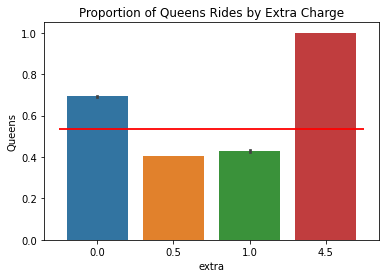

In [ ]:
#Creating Barplot split by extra charge, limited only to extra charges with a large sample
extra_barplot = sns.barplot(x="extra", y="Queens", data=df_subset_modified[df_subset_modified.extra.isin([0.0,0.5,1.0,4.5])], ci=95)
extra_barplot.axes.set_title("Proportion of Queens Rides by Extra Charge")
extra_barplot.axes.hlines(y = Queens_mean, color='red', linewidth=2, alpha=.9, xmin = -0.5, xmax = 3.5)

In [ ]:
#Changing extra to a categorical variable
def extra(row):
    if row['extra'] == 0.0:
        return '0'
    elif row['extra'] >= 4.5:
        return '4.5+'
    else:
        return '0 to 4.5'  

df_subset_modified['extra'] = df_subset_modified.apply(extra, axis=1)

# Tolls_amount
In NYC, certain bridges levy tolls and it may be helpful in identifying which borough each taxi is going towards. We first look at value counts and find that >99.9% of the data either falls into values *0.00* or *5.76*. 

I recoded **tolls_amount** as a binary indicator on toll payment then found that the proportion of *Queens* rides is much greater for rides with tolls.

In [ ]:
df_subset_modified.tolls_amount.value_counts(normalize=True) 

0.00     0.664752
5.76     0.329947
5.54     0.000910
11.52    0.000795
7.92     0.000503
           ...   
9.70     0.000003
8.79     0.000003
28.80    0.000003
11.00    0.000003
11.60    0.000003
Name: tolls_amount, Length: 191, dtype: float64

In [ ]:
#Changing tolls_amount to a categorical variable
def tolls_amount(row):
    if row['tolls_amount'] == 0.00:
        return 'None'
    else:
        return 'Paid'  

df_subset_modified['tolls_amount'] = df_subset_modified.apply(tolls_amount, axis=1)

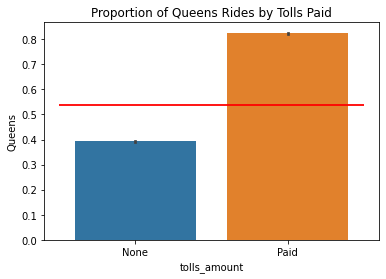

In [ ]:
#Creating Barplot split by whether a toll was paid
tolls_amount_barplot = sns.barplot(x="tolls_amount", y="Queens", data=df_subset_modified, ci=95)
tolls_amount_barplot.axes.set_title("Proportion of Queens Rides by Tolls Paid")
tolls_amount_barplot.axes.hlines(y = Queens_mean, color='red', linewidth=2, alpha=.9, xmin = -0.5, xmax = 1.5)

#store_and_fwd_flag
Dictionary defines this as a logistical flag and upon investigation, it is both rare and yields no appreciable differences between the other values. I believe this is safe to exclude as well.


In [ ]:
df_subset_modified.store_and_fwd_flag.value_counts(normalize=True)

N    0.994942
Y    0.005058
Name: store_and_fwd_flag, dtype: float64

In [ ]:
df_subset_modified.groupby('store_and_fwd_flag').mean()

,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,Queens
store_and_fwd_flag,,,,,,
N,1.581002,8.518389,28.127229,4.094580,35.400465,0.536675
Y,1.248677,8.764910,29.033598,3.822825,36.011000,0.550794


In [ ]:
#Dropping the store_and_fwd_flag column
df_subset_modified.drop('store_and_fwd_flag', axis = 1, inplace=True)

#Looking at remaining numerical variables
And with this, we have finished exploring the nature of the numerical variables we suspected may be better suited as categorical. 

When we take a look at how remaining numerical variables differ between Queens and Brooklyn rides, we can see that Queens rides tend to be longer distance by 3.5 miles on average and with higher *tip_amounts*.

In [ ]:
df_subset_modified.groupby('Queens').mean()

,passenger_count,trip_distance,fare_amount,tip_amount,total_amount
Queens,,,,,
0,1.564327,6.639527,23.63617,3.194569,28.812992
1,1.592262,10.142314,32.01190,4.868798,41.091715


# Addressing Collinearity

After transforming and created more suitable categorical variables, we look again at a much more manageable pair of pairplots and correlation heatmaps. We still need to address our collinearity issue with **trip_distance, tip_amount, fare_amount,** and **total_amount**. 

We know from looking at the rows that **total_amount** is actually a sum of **tip_amount** and **fare_amount** and the other miscelleanous fares. Also, **fare_amount** is a linear function of **trip_distance** as sourced from [the NYC Taxi site](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page). We note however, that despite **trip_distance** being nearly perfectly correlated with **fare_amount** and **total_amount**, it is only moderately correlated with **tip_amount**.

Thus I propose that we keep **tip_amount** and **trip_distance** as they seem most likely to capture different kinds of information. 

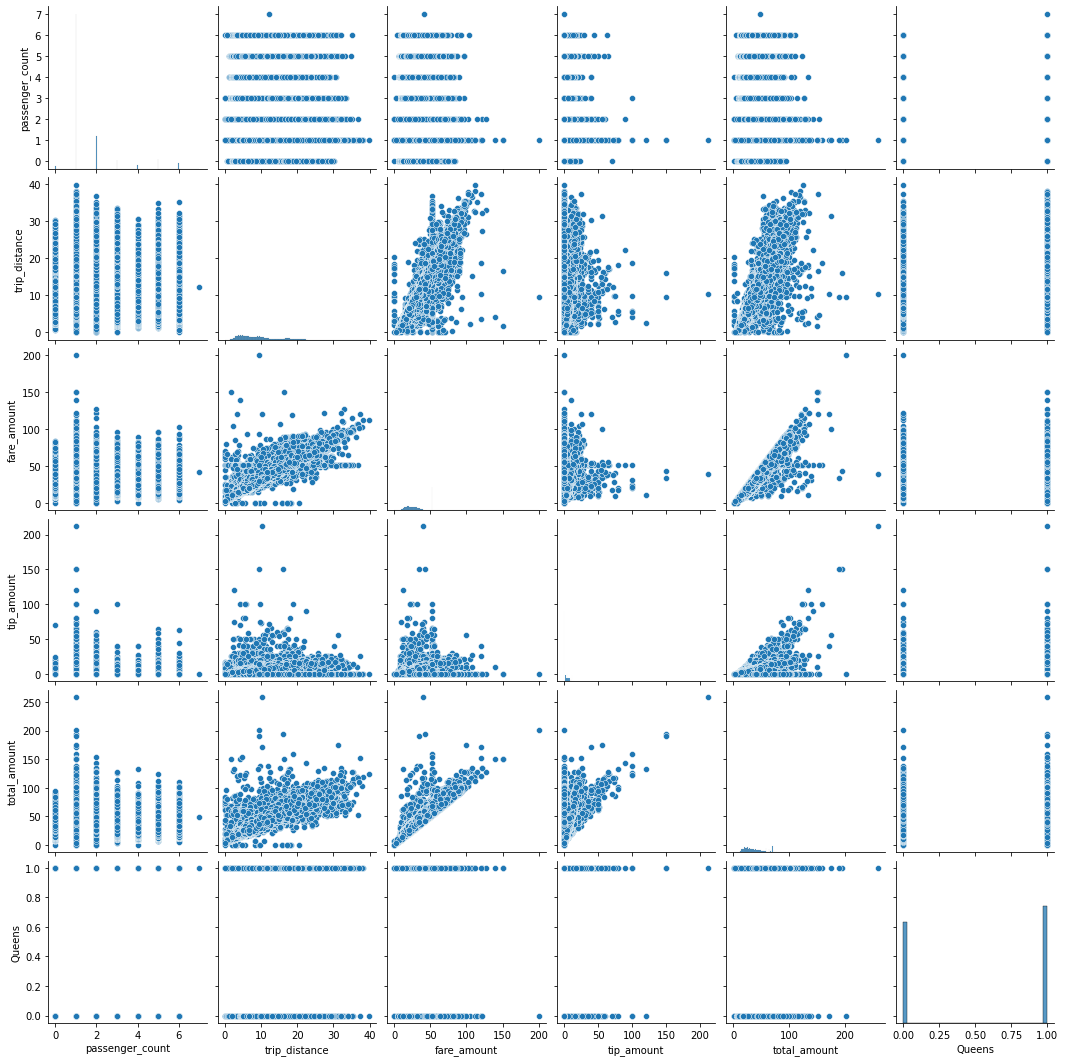

In [ ]:
sns.pairplot(df_subset_modified)

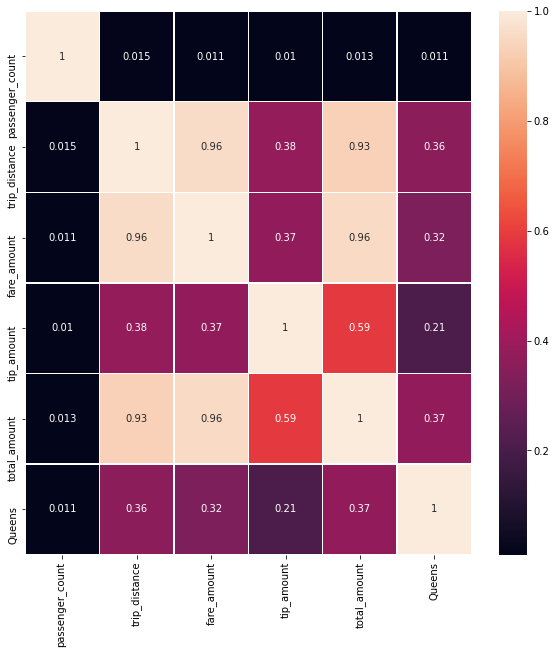

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(data=df_subset_modified.corr(), annot=True, linewidths=.5, ax=ax)

In [ ]:
#Discarding the redundant Fare Amount and Total Amount columns
df_subset_modified.drop(['fare_amount','total_amount'],axis=1, inplace=True)

#Leveraging our datetime columns

We have time metrics in the form of **pickup_datetime** and **dropoff_datetime**. From these, we could create a new metric that may be more easily useable in the form of **part_of_day** (*Morning*, *Afternoon*, *Evening*, *Night*) from **pickup_datetime**. The duration of ride may also be of interest but also likely will introduce collinearity issues with **trip_distance** so I will do without it.

In [ ]:
#Taking a quick look at the hour distributions
df_subset_modified.pickup_datetime.dt.hour.value_counts() 

#Modifying based on hour of pickup
def part_of_day(row):
    if (row['pickup_datetime'].hour >= 5 and row['pickup_datetime'].hour <= 12):
        return 'Morning'
    elif (row['pickup_datetime'].hour >= 13 and row['pickup_datetime'].hour <= 17):
        return 'Afternoon' 
    elif (row['pickup_datetime'].hour >= 18 and row['pickup_datetime'].hour <= 22):
        return 'Evening' 
    else:
        return 'Night'

df_subset_modified['part_of_day'] = df_subset_modified.apply(part_of_day, axis=1)

We find that the dataset mean for Queens is included in none of the Confidence Intervals for each **part_of_day** which is promising.

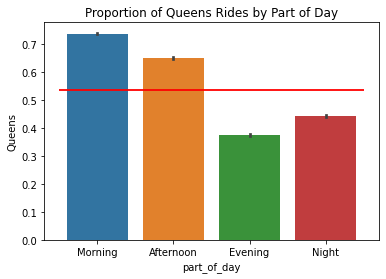

In [ ]:
#Creating Barplot split by part of day
part_of_day_barplot = sns.barplot(x="part_of_day", y="Queens", data=df_subset_modified, ci=95, order = ['Morning','Afternoon','Evening','Night'])
part_of_day_barplot.axes.set_title("Proportion of Queens Rides by Part of Day")
part_of_day_barplot.axes.hlines(y = Queens_mean, color='red', linewidth=2, alpha=.9, xmin = -0.5, xmax = 3.5)

#Broad look all the categorical and numerical variables we created


In [ ]:
#Creating lists of features based on type
numerical = ['passenger_count', 'trip_distance', 'tip_amount']
categorical = ['VendorID', 'payment_type', 'extra', 'tolls_amount', 'part_of_day']

#Final df after cleaning
df_final = df_subset_modified[numerical+categorical+['Zone_dropoff', 'Queens']]

#Contrasting Queens and Brooklyn with Count Plots
Summarizing broad takeaways

1.   **VendorID** distributions are similar
2.   Queens **pays** slightly more often by *Cash* but similar across both.
3. Queens is mostly 0 and high **extra** fees and Brooklyn is primary in the middle.
4. A slight majority of Queens rides involve a **Toll** paid.
5. Queens rides are more often in the first part of the day and conversely for Brooklyn.



Text(0.5, 1.0, 'Countplot of Part of Day Brooklyn')

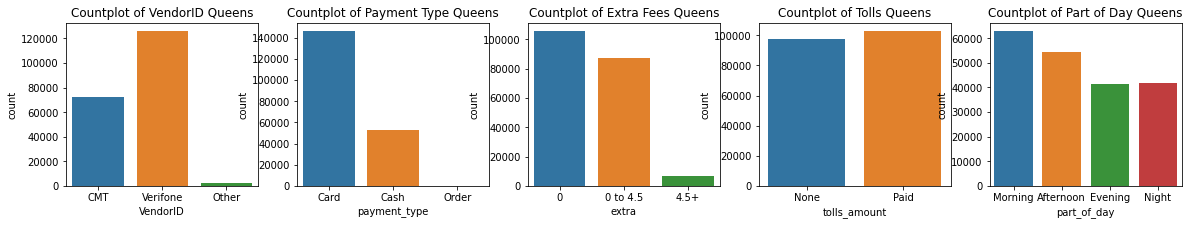

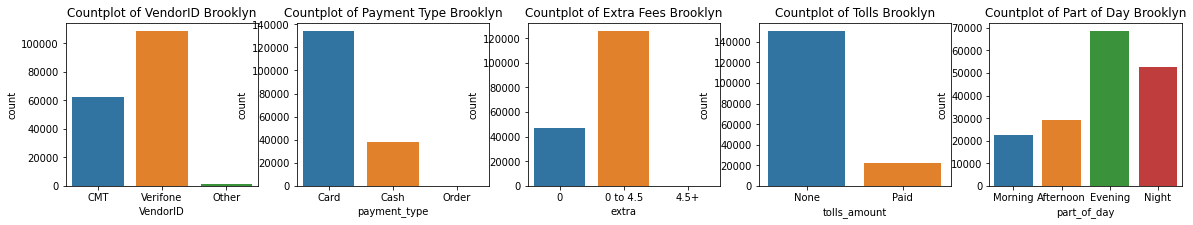

In [ ]:
#Plotting the characteristics of Queens
fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(20, 3))
sns.countplot(x = df_final[df_final.Queens == 1]['VendorID'],ax=ax1, order = ['CMT','Verifone','Other'])
ax1.set_title("Countplot of VendorID Queens")
sns.countplot(x = df_final[df_final.Queens == 1]['payment_type'], ax=ax2, order = ['Card','Cash','Order'])
ax2.set_title("Countplot of Payment Type Queens")
sns.countplot(x = df_final[df_final.Queens == 1]['extra'], ax=ax3, order = ['0','0 to 4.5','4.5+'])
ax3.set_title("Countplot of Extra Fees Queens")
sns.countplot(x = df_final[df_final.Queens == 1]['tolls_amount'],ax=ax4, order = ['None', 'Paid'])
ax4.set_title("Countplot of Tolls Queens")
sns.countplot(x = df_final[df_final.Queens == 1]['part_of_day'],ax=ax5, order = ['Morning','Afternoon','Evening','Night'])
ax5.set_title("Countplot of Part of Day Queens")

#Plotting the characteristics of Brooklyn
fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(20, 3))
sns.countplot(x = df_final[df_final.Queens == 0]['VendorID'],ax=ax1, order = ['CMT','Verifone','Other'])
ax1.set_title("Countplot of VendorID Brooklyn")
sns.countplot(x = df_final[df_final.Queens == 0]['payment_type'], ax=ax2, order = ['Card','Cash','Order'])
ax2.set_title("Countplot of Payment Type Brooklyn")
sns.countplot(x = df_final[df_final.Queens == 0]['extra'], ax=ax3, order = ['0','0 to 4.5','4.5+'])
ax3.set_title("Countplot of Extra Fees Brooklyn")
sns.countplot(x = df_final[df_final.Queens == 0]['tolls_amount'],ax=ax4, order = ['None', 'Paid'])
ax4.set_title("Countplot of Tolls Brooklyn")
sns.countplot(x = df_final[df_final.Queens == 0]['part_of_day'],ax=ax5, order = ['Morning','Afternoon','Evening','Night'])
ax5.set_title("Countplot of Part of Day Brooklyn")

#Categorical Interactions
To explore how our 5 categorical variables interact, I plotted 10 (5 choose 2) grouped barplots to see their effects on each other. Main findings:



*   **VendorID** seems to have no effect on the distributions of any other variables.
*   **Part_of_day** seems to vary greatly.
  * *Evening* rides are most common by far for those who **pay** by *Card*.
  * *Evening* and *night* rides dominate for *0 to 4.5* **Extra** fees.
  * *Evening* and *night* behave similarly for no **Tolls**.
* Those who pay *0 to 4.5* **Extra** fees rarely pay a **Toll**.



Text(0.5, 1.0, 'Part of Day vs Tolls Paid')

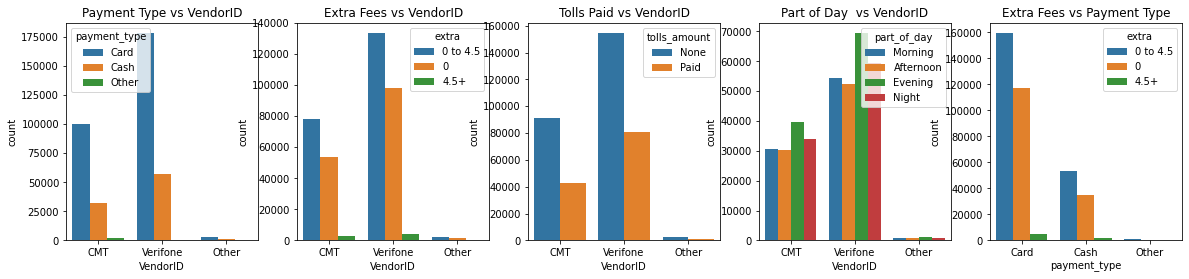

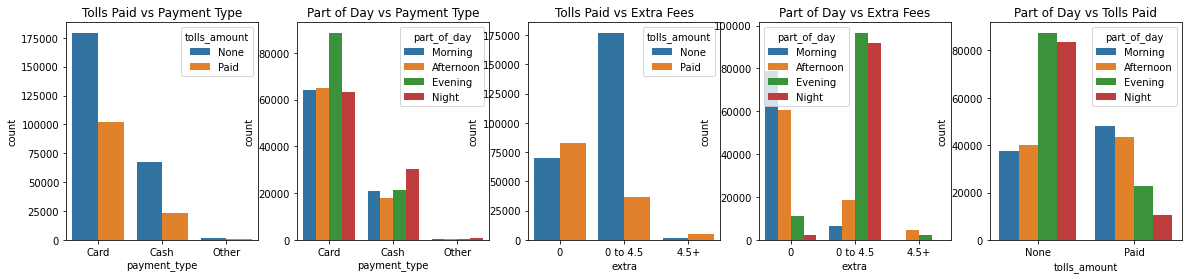

In [ ]:
#Creating 10 plots for categorical interaction investigation
fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(20, 4))
sns.countplot(x="VendorID", hue="payment_type", data=df_final,ax=ax1, order = ['CMT','Verifone','Other'])
ax1.set_title("Payment Type vs VendorID")
sns.countplot(x="VendorID", hue="extra", data=df_final,ax=ax2, order = ['CMT','Verifone','Other'])
ax2.set_title("Extra Fees vs VendorID")
sns.countplot(x="VendorID", hue="tolls_amount", data=df_final,ax=ax3, order = ['CMT','Verifone','Other'])
ax3.set_title("Tolls Paid vs VendorID")
sns.countplot(x="VendorID", hue="part_of_day", data=df_final,ax=ax4, order = ['CMT','Verifone','Other'], hue_order= ['Morning','Afternoon','Evening','Night'])
ax4.set_title("Part of Day  vs VendorID")
sns.countplot(x="payment_type", hue="extra", data=df_final,ax=ax5, order = ['Card','Cash','Other'])
ax5.set_title("Extra Fees vs Payment Type")

#New row
fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(20, 4))
sns.countplot(x="payment_type", hue="tolls_amount", data=df_final,ax=ax1, order = ['Card','Cash','Other'])
ax1.set_title("Tolls Paid vs Payment Type")
sns.countplot(x="payment_type", hue="part_of_day", data=df_final,ax=ax2, order = ['Card','Cash','Other'], hue_order= ['Morning','Afternoon','Evening','Night'])
ax2.set_title("Part of Day vs Payment Type")
sns.countplot(x="extra", hue="tolls_amount", data=df_final,ax=ax3, order = ['0','0 to 4.5','4.5+'])
ax3.set_title("Tolls Paid vs Extra Fees")
sns.countplot(x="extra", hue="part_of_day", data=df_final,ax=ax4, order = ['0','0 to 4.5','4.5+'], hue_order= ['Morning','Afternoon','Evening','Night'])
ax4.set_title("Part of Day vs Extra Fees")
sns.countplot(x="tolls_amount", hue="part_of_day", data=df_final,ax=ax5, order = ['None', 'Paid'], hue_order= ['Morning','Afternoon','Evening','Night'])
ax5.set_title("Part of Day vs Tolls Paid")

#Right Skew
We can see from all our remaining numerical data exhibit some right skew, which is common in count and financial data. 

We may consider alleviating this skew with a log transform in the modeling step. Non-normality in variables isn't problematic in and of itself but it can sometimes lead to a skew in residuals, in which case would lead to non-normal residual, violating one of the assumptions of regression.

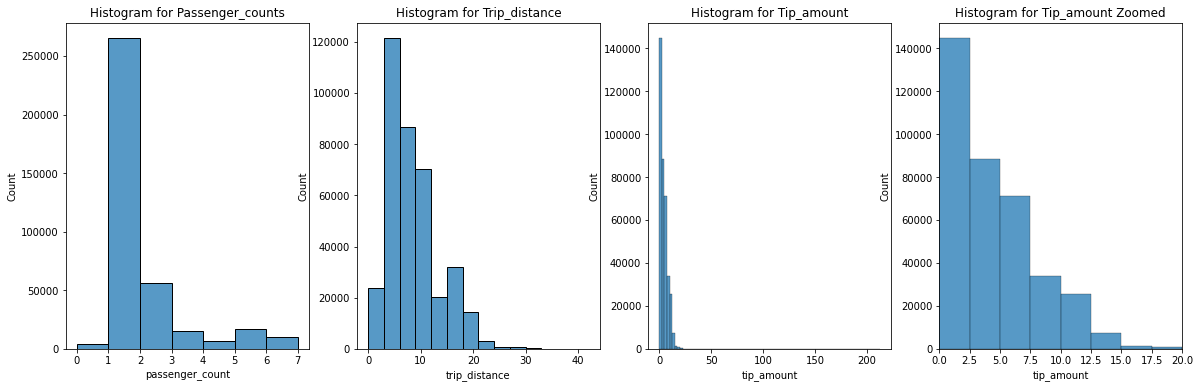

In [ ]:
## Plotting multiple plots same figure
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1,4, figsize=(20,6))

#Histogram for Passenger_counts
sns.histplot(data = df_final, x="passenger_count", binwidth=1, ax= ax1)
ax1.set_title("Histogram for Passenger_counts")

#Histogram for trip_distance
sns.histplot(data = df_final, x="trip_distance", binwidth=3, ax= ax2)
ax2.set_title("Histogram for Trip_distance")

#Histogram for tip_amount
sns.histplot(data = df_final, x="tip_amount", binwidth=2.5, ax= ax3) 
ax3.set_title("Histogram for Tip_amount")

#Creating Zoomed Histograms

#Histogram for tip_amount
sns.histplot(data = df_final, x="tip_amount", binwidth=2.5, ax= ax4) 
ax4.set_xlim(0,20)
ax4.set_title("Histogram for Tip_amount Zoomed")

plt.show()

### Modeling Time

This is your time to shine. We aren't as concerned with your model accuracy and such as the way you approach your model. 
* What model do you choose and why? 
* What parameters are you choosing for your model? 
* What are important considerations you're taking into account while modeling? 
* How are you measuring model performance? 

#Logistic Regression
While digging through the data, I was mainly considering between a **random forest classifier** and **logistic regression**. Given the emphasis on interpretability over sheer accuracy and fear of **random forest** taking too long to train for a dataset of this size, I went with a **logistic regression**. 

We aim to create a model that classifies well while still being accessible to others. We are also interested in determining which areas the model underperforms on which we could easily figure out via the coefficients of a regression model. 

Some considerations we want to keep in mind.


*   We are operating under the assumption that our features are independent and linearly affect the log odds.
*   We want to be wary of **p-values** and instead emphasize effect sizes of our coefficients because our sample is so large. We will very likely [find statistical significance](https://www.galitshmueli.com/system/files/Largesample-12-6-2012.pdf) at the 0.05 alpha level due to standard errors shrinking so we want to ensure that our effect sizes aren't trivial.
*   The outcome variable is fairly balanced so we can do without resampling techniques or stratifying before splitting into train and test. Also, our primary performance metric will likely be **accuracy** due to the class balance.




#Feature Selection
There are a few options we have with selecting features. There are criterion based techniques like **AIC** or automatic selection methods. We can also choose between **Forward, Backwards, Stepwise selection**. Since we only have a few features of interest, I'm going to attempt **Backwards selection**, fitting the model with all variables and updating the model by removing a feature at a time.


In [ ]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf

y = df_final['Queens']

#Taking in all the features as dependent variables 
X = df_final[numerical+categorical]

#Splitting our dataset to 70/30 train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#statsmodels uses a different format for modeling logit so I have to recombine X_train and y_train here
smf_Train = X_train
smf_Train = smf_Train.assign(Queens = y_train)
smf_Train

#Creating the first model with all features
model = smf.logit("Queens ~ passenger_count + trip_distance + tip_amount + C(VendorID) + C(payment_type) + C(extra) + C(tolls_amount) + C(part_of_day)", data = smf_Train).fit()
model.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.555636
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Queens   No. Observations:               261587
Model:                          Logit   Df Residuals:                   261573
Method:                           MLE   Df Model:                           13
Date:                Tue, 16 Feb 2021   Pseudo R-squ.:                  0.1953
Time:                        08:00:18   Log-Likelihood:            -1.4535e+05
converged:                       True   LL-Null:                   -1.8063e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.2568      0.018    -69.944      0.000      -1.292      -1.222
C(VendorID)[T.Other]         -0.0433      0.046     -0.940      0.347      -0.134       0.047
C(VendorID)[T.Verifone]      -0.0491      0.010     -5.054      0.000      -0.068      -0.030
C(payment_type)[T.Cash]       1.0527      0.013     78.212      0.000       1.026       1.079
C(payment_type)[T.Other]      0.8403      0.060     13.904      0.000       0.722       0.959
C(extra)[T.0 to 4.5]         -0.2579      0.015    -16.819      0.000      -0.288      -0.228
C(extra)[T.4.5+]              6.2318      0.708      8.807      0.000       4.845       7.619
C(tolls_amount)[T.Paid]       1.3482      0.012    112.188      0.000       1.325       1.372
C(part_of_day)[T.Evening]    -0.3943      0.016    -24.396      0.000      -0.426      -0.363
C(part_of_day)[T.Morning]     0.3606      0.014     24.929      0.000       0.332       0.389
C(part_of_day)[T.Night]       0.0689      0.017      4.006      0.000       0.035       0.103
passenger_count               0.0012      0.004      0.328      0.743      -0.006       0.009
trip_distance                 0.0553      0.001     43.969      0.000       0.053       0.058
tip_amount                    0.1255      0.002     67.175      0.000       0.122       0.129
=============================================================================================
"""

#Dropping Passenger_count
Looking at the full model with all variables, we find that **Passenger_count**'s **p-value** is far greater than 0.05. When referencing means grouped by **passenger_count**, I found no meaningful relationship so I feel safe omitting **passenger_count** from our model in our second attempt.

In [ ]:
#Taking a quick look at properties by passenger counts
df_final.groupby('passenger_count').mean()

,trip_distance,tip_amount,Queens
passenger_count,,,
0,8.442864,4.153453,0.543459
1,8.441219,4.070802,0.532539
2,8.794392,4.148630,0.544443
3,8.672203,4.044592,0.553736
4,8.907690,3.861474,0.557609
5,8.453827,4.233729,0.538905
6,8.724077,4.348712,0.559852
7,12.200000,0.000000,1.000000


In [ ]:
model2 = smf.logit("Queens ~  trip_distance + tip_amount + C(VendorID) + C(payment_type) + C(extra) + C(tolls_amount) + C(part_of_day)", data = smf_Train).fit()
model2.summary()

Optimization terminated successfully.
         Current function value: 0.555637
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Queens   No. Observations:               261587
Model:                          Logit   Df Residuals:                   261574
Method:                           MLE   Df Model:                           12
Date:                Tue, 16 Feb 2021   Pseudo R-squ.:                  0.1953
Time:                        08:00:25   Log-Likelihood:            -1.4535e+05
converged:                       True   LL-Null:                   -1.8063e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.2555      0.017    -71.795      0.000      -1.290      -1.221
C(VendorID)[T.Other]         -0.0436      0.046     -0.945      0.345      -0.134       0.047
C(VendorID)[T.Verifone]      -0.0484      0.009     -5.113      0.000      -0.067      -0.030
C(payment_type)[T.Cash]       1.0529      0.013     78.302      0.000       1.027       1.079
C(payment_type)[T.Other]      0.8405      0.060     13.907      0.000       0.722       0.959
C(extra)[T.0 to 4.5]         -0.2578      0.015    -16.819      0.000      -0.288      -0.228
C(extra)[T.4.5+]              6.2319      0.708      8.807      0.000       4.845       7.619
C(tolls_amount)[T.Paid]       1.3482      0.012    112.188      0.000       1.325       1.372
C(part_of_day)[T.Evening]    -0.3943      0.016    -24.396      0.000      -0.426      -0.363
C(part_of_day)[T.Morning]     0.3606      0.014     24.930      0.000       0.332       0.389
C(part_of_day)[T.Night]       0.0690      0.017      4.010      0.000       0.035       0.103
trip_distance                 0.0553      0.001     43.968      0.000       0.053       0.058
tip_amount                    0.1256      0.002     67.245      0.000       0.122       0.129
=============================================================================================
"""

#Dropping VendorID
Looking at the model again, we find that the only **p-value** greater than 0.05 remaining belongs to the *Other* value of **VendorID**. This matches intuition given that the *Other* value was rare and did not seem to differ greatly. 

Normally, we could leave an insigificant dummy variable for a category alone but given that our previous plot of **VendorID** yield almost exactly equal *Queens* ride rate, I believe it is safe to omit **VendorID**. The effect size is very small, which harkens back to the point earlier about not making decisions entirely based on **p-values**, especially for large samples.

In [ ]:
model3 = smf.logit("Queens ~  trip_distance + tip_amount + C(payment_type) + C(extra) + C(tolls_amount) + C(part_of_day)", data = smf_Train).fit()
model3.summary()

Optimization terminated successfully.
         Current function value: 0.555687
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Queens   No. Observations:               261587
Model:                          Logit   Df Residuals:                   261576
Method:                           MLE   Df Model:                           10
Date:                Tue, 16 Feb 2021   Pseudo R-squ.:                  0.1953
Time:                        08:00:30   Log-Likelihood:            -1.4536e+05
converged:                       True   LL-Null:                   -1.8063e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.2860      0.016    -78.203      0.000      -1.318      -1.254
C(payment_type)[T.Cash]       1.0545      0.013     78.451      0.000       1.028       1.081
C(payment_type)[T.Other]      0.8734      0.060     14.537      0.000       0.756       0.991
C(extra)[T.0 to 4.5]         -0.2564      0.015    -16.731      0.000      -0.286      -0.226
C(extra)[T.4.5+]              6.2364      0.708      8.814      0.000       4.850       7.623
C(tolls_amount)[T.Paid]       1.3468      0.012    112.124      0.000       1.323       1.370
C(part_of_day)[T.Evening]    -0.3960      0.016    -24.504      0.000      -0.428      -0.364
C(part_of_day)[T.Morning]     0.3606      0.014     24.933      0.000       0.332       0.389
C(part_of_day)[T.Night]       0.0670      0.017      3.893      0.000       0.033       0.101
trip_distance                 0.0550      0.001     43.819      0.000       0.053       0.057
tip_amount                    0.1260      0.002     67.528      0.000       0.122       0.130
=============================================================================================
"""

#Arriving at our final model
We are now left with just 6 features: **payment_type, extra, tolls_amount, part_of_day, trip_distance,** and **tip_amount**. All of these have moderate to strong effect sizes; the lowest of which is **trip_distance** at 0.055 but this is fine as it increments per mile. 

Example interpretation: all else held constant, the **Log Odds** of a ride heading to **Queens** increases by 0.055 per additional mile the ride takes. **Log Odds** is a bit difficult to grasp an intuition around and interpret however, so lets take a look at **Odds Ratios**.

In [ ]:
#Creating Odds Ratios and their Confidence Intervals for easier intepreting
model_odds = pd.DataFrame(np.exp(model3.params), columns= ['OR'])
model_odds[['2.5%', '97.5%']] = np.exp(model3.conf_int())
model_odds

,OR,2.5%,97.5%
Intercept,0.276363,0.267598,0.285416
C(payment_type)[T.Cash],2.870597,2.795958,2.947229
C(payment_type)[T.Other],2.395149,2.129063,2.694491
C(extra)[T.0 to 4.5],0.773807,0.750907,0.797405
C(extra)[T.4.5+],511.032760,127.691842,2045.193158
C(tolls_amount)[T.Paid],3.845279,3.755806,3.936883
C(part_of_day)[T.Evening],0.673038,0.652056,0.694694
C(part_of_day)[T.Morning],1.434224,1.394136,1.475464
C(part_of_day)[T.Night],1.069261,1.033813,1.105924
trip_distance,1.056553,1.053956,1.059156


**Example of Odds**: Odds relate to probability (p) as Odds = p/(1-p). Re-expressed, p = Odds/(1 + Odds). **1:1** odds means p = 1/(1+1) = 1/2. 

**Odds Ratios** less than 1 indicates a decreased odds factor and vice versa.

Paying a Toll turns **1:1** odds to **3.8:1** Odds. Going to probabilities, 3.8/(1+3.8) = 80%. This turns a 50% probability of going to **Queens** to 80%!

For every additional mile traveled, all else held constant, odds of the trip going to **Queens** increases by a factor of 1.056.

We see that the strongest singular factor is high **Extra** fees and paying a **tolls_amount** which matches the intuition gained from data digging.

#Evaluating the model
Before we even move onto performance, we want to run **Diagnostics** to confirm that our model is valid and suitable for logistic regression.

On the **Performance** end, we identified that we want to primarily look at accuracy but for the interests of understanding how our model predicts, we should also look at Precision, Recall, and the ROC curve. 

#Diagnostics
To diagnose our modes and ensure that they fit the assumptions we have laid out, one technique is to take a look at residuals. 

We will be looking at plots of **Pearson residuals** and **Deviance residuals**, against the linear fitted values with a Lowess smooth. A valid model will have a Lowess smooth that resembles a horizontal intercept at 0.

We find that our Lowess smooth does resemble the desired intercept. However, we also uncover that some of the **Pearson Residuals** are quite negative, which indicates some values that we still misclassified despite high predicted probability. Looking into these outliers could be helpful.

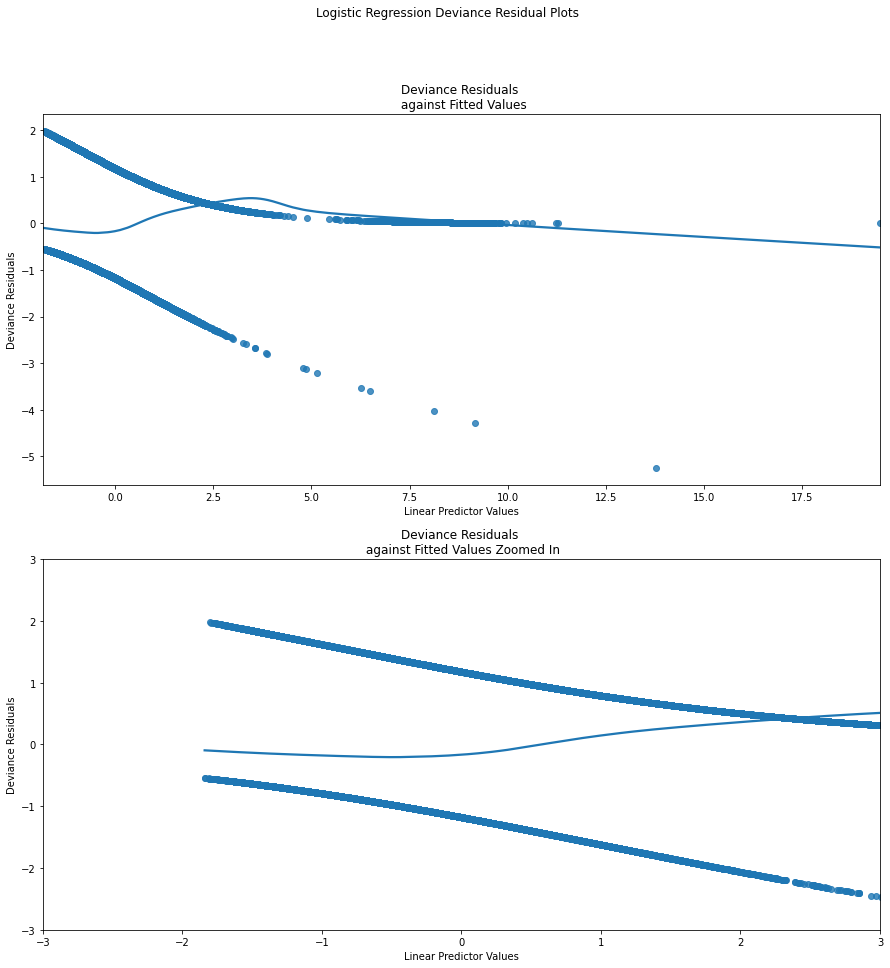

In [ ]:
#Running lowess from a large population takes too long to run so I will plot a sample of 50,000 values

## Plotting multiple plots same figure
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Deviance Residual Plots")

# Deviance Residuals
sns.regplot(x = model3.fittedvalues[:50000], y = model3.resid_dev[:50000], ax= axL, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

# Deviance Residuals zoomed in
sns.regplot(x = model3.fittedvalues[:50000], y = model3.resid_dev[:50000], ax= axR, lowess=True)

axR.set_title("Deviance Residuals \n against Fitted Values Zoomed In")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Deviance Residuals")
axR.set_xlim(-3,3)
axR.set_ylim(-3,3)

plt.show()

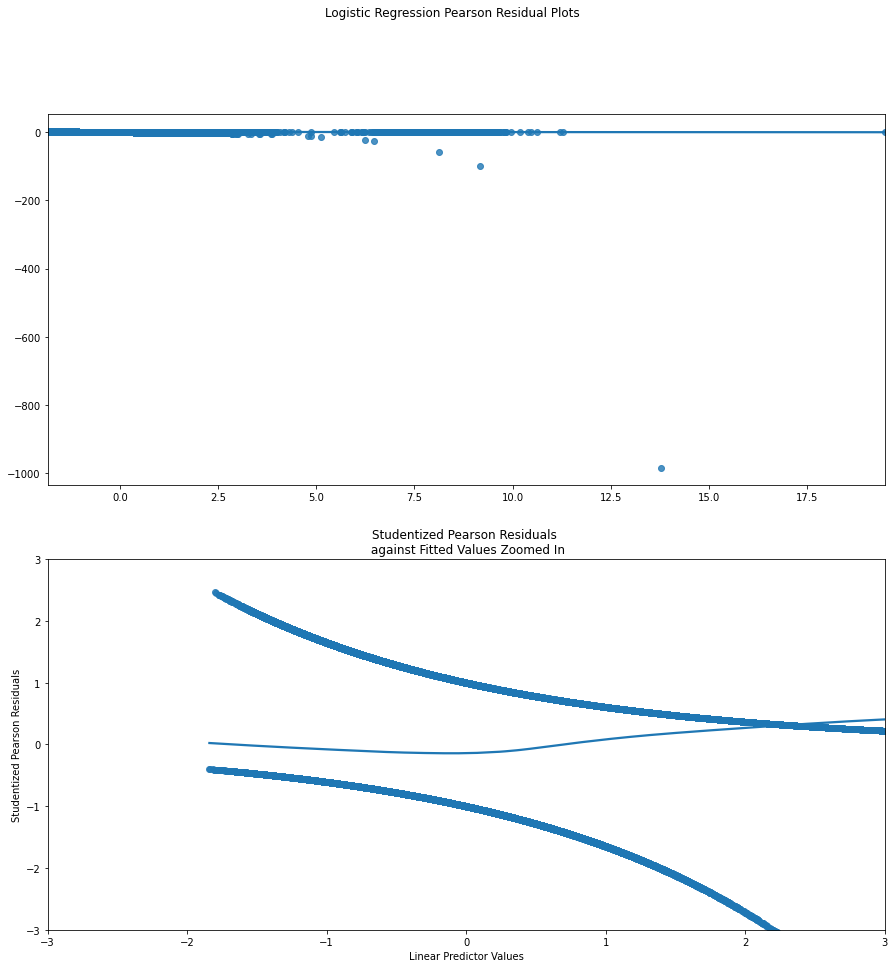

In [ ]:
## Plotting multiple plots same figure
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Pearson Residual Plots")

# Pearson Residuals
sns.regplot(x = model3.fittedvalues[:50000], y = model3.resid_pearson[:50000], ax= axL, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")

# Pearson Residuals zoomed in
sns.regplot(x = model3.fittedvalues[:50000], y = model3.resid_pearson[:50000], ax= axR, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values Zoomed In")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")
axR.set_xlim(-3,3)
axR.set_ylim(-3,3)

plt.show()

#Performance
We set aside 30% of our data for testing and train our model on 70% of the dataset.

**Accuracy: 70%** Our model classifies the test data correctly 70% of the time. 

**Precision: 75%** Among all the values that the model predicts as Queens rides, 75% are actually Queens.

**Recall: 65%** Among all values that are actually Queens rides, 65% of them were correctly identified as Queens.


In [ ]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

y = df_final['Queens']

#Sklearn uses slightly different inputs than statsmodel so I have to recreate the variables and create dummy variables
#We remove VendorID and passenger_count here while feature selecting
X_train = X_train.drop(['VendorID','passenger_count'], axis=1)
X_train = pd.get_dummies(data=X_train, drop_first=True)	

X_test = X_test.drop(['VendorID','passenger_count'], axis=1)
X_test = pd.get_dummies(data=X_test, drop_first=True)	

#Running the regression again in sklearn
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

#Predicting and printing Accuracy
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.70


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Creating a confusion matrix, which gives us the breakdown of false positives and negatives
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))

[[38986 12797]
 [20990 39336]]
              precision    recall  f1-score   support

           0       0.65      0.75      0.70     51783
           1       0.75      0.65      0.70     60326

    accuracy                           0.70    112109
   macro avg       0.70      0.70      0.70    112109
weighted avg       0.71      0.70      0.70    112109



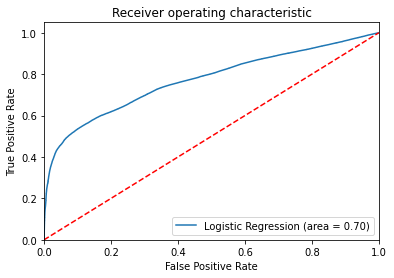

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#ROC Curves give us insight at how our positive rates performs at varying classification threshold levels
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Interpretations

Now that you have a model trained on the entire population, we're interested in its performance in specific dropoff neighborhoods. 
Some things to consider:
* What seems to drive the performance in each neighborhood?
* Can you explain any differences you see in performance?
* There's no need to retrain the model with your findings, but what approaches would you take if you were to retrain?

#Identifying Neighborhoods
We want to identify 3 types of neighborhoods.

**Poorly Performing**: *Astoria* with a 12% correct classification.

**Randomly Peforming**: *Maspeth* with a 53% correct classification.

**Strong Performing**: *JFK Airport* with a 99% correct classification.

In [ ]:
#Recreating dummies for predicting whole dataset
X = X.drop(['VendorID','passenger_count'], axis=1)
X = pd.get_dummies(data=X, drop_first=True)	

#Leveraging the predictions and probabilities from our regression model
y_pred = logreg.predict(X)
y_prob = [i[1] for i in logreg.predict_proba(X)]

#Appending to the final data set
df_final_pred = df_final

df_final_pred = df_final_pred.assign(Prediction = y_pred)
df_final_pred = df_final_pred.assign(Probability = y_prob)

df_final_pred = df_final_pred.assign(Correct = (df_final_pred['Queens'] == df_final_pred['Prediction']))
df_final_pred.groupby('Zone_dropoff')['Correct'].mean().sort_values()

Zone_dropoff
Long Island City/Queens Plaza    0.107773
Astoria                          0.122142
Manhattan Beach                  0.129353
Brighton Beach                   0.130769
Coney Island                     0.144712
                                   ...   
Douglaston                       0.945355
Hammels/Arverne                  0.957895
LaGuardia Airport                0.960278
Rockaway Park                    0.990000
JFK Airport                      0.995177
Name: Correct, Length: 129, dtype: float64

We quickly create indicator variables for these regions for easier comparison.

In [ ]:
#3 indicator variables for dropoff zones
df_final_pred['Maspeth'] = np.where(df_final_pred['Zone_dropoff'] == 'Maspeth', True, False)
df_final_pred['JFK Airport'] = np.where(df_final_pred['Zone_dropoff'] == 'JFK Airport', True, False)
df_final_pred['Astoria'] = np.where(df_final_pred['Zone_dropoff'] == 'Astoria', True, False)

# Astoria compared to the rest of Queens
We find that *Astoria* is drastically underpredicted as a **Queens** ride and thus we explore the differences between the Astoria and Queens.


*   Trips to Astoria are on average half the **trip_distance** and **tip_amount**, both positive Odds Ratio at 1.056 and 1.134 respectively.

*   Most **Queens** riders either pay no fees or high fees but *Astoria* riders primarily pay *0 to 4.5* with a negative Odds Ratio factor of 0.77.

*   Astoria rider also almost never need to pay toll fees whereas the average **Queens** rider does, one of our strongest effect sizes at 3.845. 

*   Also, we find that rides to *Astoria* are almost never in the *morning* or *afternoon* and *morning* is one of the higher Odds Ratios at 1.434


In [ ]:
#Comparing Astoria to the rest of Queens
df_final_pred[(df_final_pred.Queens == 1)].groupby('Astoria')[['trip_distance', 'tip_amount','Probability','Correct']].mean()

,trip_distance,tip_amount,Probability,Correct
Astoria,,,,
False,10.597519,5.078214,0.671809,0.699752
True,5.189104,2.590085,0.373005,0.122142


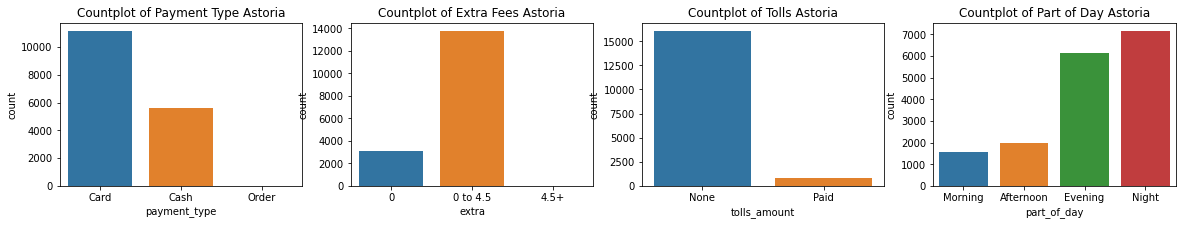

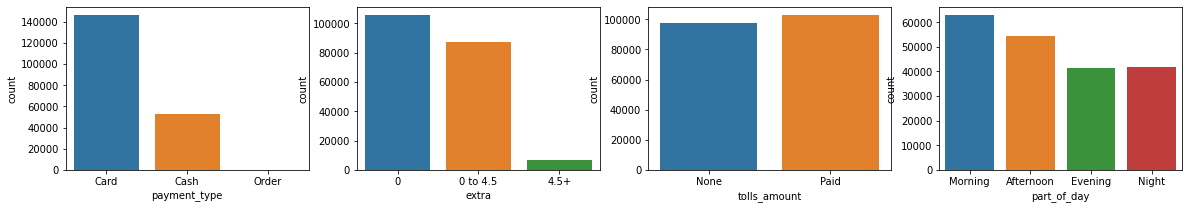

In [ ]:
#Plotting the characteristics of Astoria
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(20, 3))
sns.countplot(x = df_final_pred[df_final_pred.Zone_dropoff == 'Astoria']['payment_type'], ax=ax1, order = ['Card','Cash','Order'])
ax1.set_title("Countplot of Payment Type Astoria")
sns.countplot(x = df_final_pred[df_final_pred.Zone_dropoff == 'Astoria']['extra'], ax=ax2, order = ['0','0 to 4.5','4.5+'])
ax2.set_title("Countplot of Extra Fees Astoria")
sns.countplot(x = df_final_pred[df_final_pred.Zone_dropoff == 'Astoria']['tolls_amount'], ax=ax3, order = ['None', 'Paid'])
ax3.set_title("Countplot of Tolls Astoria")
sns.countplot(x = df_final_pred[df_final_pred.Zone_dropoff == 'Astoria']['part_of_day'], ax=ax4, order = ['Morning','Afternoon','Evening','Night'])
ax4.set_title("Countplot of Part of Day Astoria")

#Plotting the characteristics of Queens
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(20, 3))
sns.countplot(x = df_final_pred[df_final_pred.Queens == 1]['payment_type'], ax=ax1, order = ['Card','Cash','Order'])
sns.countplot(x = df_final_pred[df_final_pred.Queens == 1]['extra'], ax=ax2, order = ['0','0 to 4.5','4.5+'])
sns.countplot(x = df_final_pred[df_final_pred.Queens == 1]['tolls_amount'],ax=ax3, order = ['None', 'Paid'])
sns.countplot(x = df_final_pred[df_final_pred.Queens == 1]['part_of_day'],ax=ax4, order = ['Morning','Afternoon','Evening','Night'])

# Maspeth compared to the rest of Queens
We find that *Maspeth* is predicted completely randomly and we investigate the difference between it and Queens.


*   The average **trip_distance** to *Maspeth* is lower than that of to **Queens** by 3 miles. **Tip_amount** is similarly lower. Both indicate *Brooklyn*.
*   A slight majority of *Maspeth* riders **pay** by *Cash*, which suggests *Queens*.
*   Many riders still pay **tolls** but less so than the Queens average. This indicates *Queens* but to a lesser degree than other Queens districts.
* Most rides to *Maspeth* take place in the *evening* and *night*, which are more characteristic of *Brooklyn* rides. 

The profile for *Maspeth* is similar to *Astoria*. They both have shorter **trip_distances**, less **tip_amount**, operate at the same **part_of_day** and have similar **extra** fees distribution. he presence of **Toll** fees and **Cash** payments prevents *Maspeth* from misclassifying as much as *Astoria*.

In [ ]:
#Comparing Maspeth to the rest of Queens
df_final_pred[(df_final_pred.Queens == 1)].groupby('Maspeth')[['trip_distance', 'tip_amount','Probability','Correct']].mean()

,trip_distance,tip_amount,Probability,Correct
Maspeth,,,,
False,10.161289,4.885754,0.647215,0.651830
True,6.813958,1.894582,0.549348,0.529464


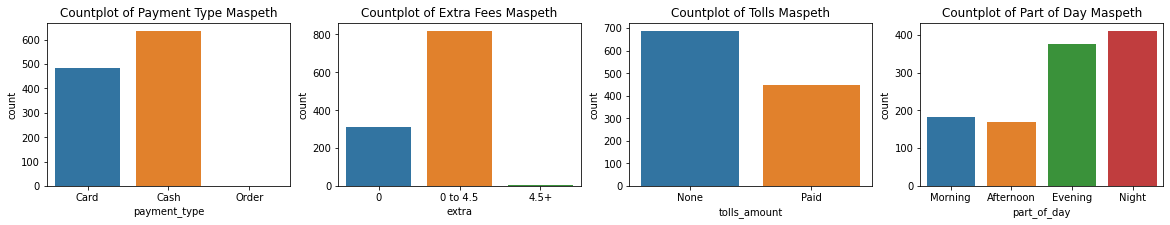

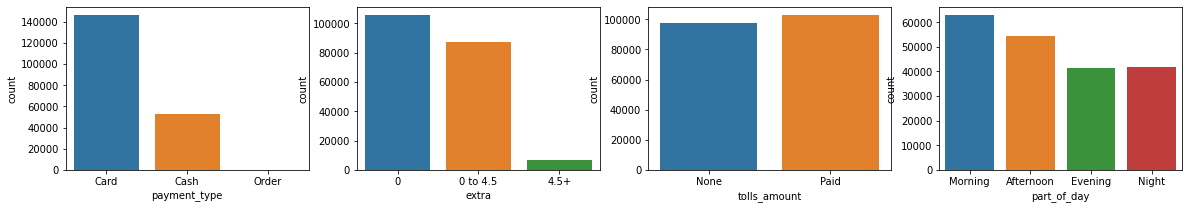

In [ ]:
#Plotting the characteristics of Maspeth
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(20, 3))
sns.countplot(x = df_final_pred[df_final_pred.Zone_dropoff == 'Maspeth']['payment_type'], ax=ax1, order = ['Card','Cash','Order'])
ax1.set_title("Countplot of Payment Type Maspeth")
sns.countplot(x = df_final_pred[df_final_pred.Zone_dropoff == 'Maspeth']['extra'], ax=ax2, order = ['0','0 to 4.5','4.5+'])
ax2.set_title("Countplot of Extra Fees Maspeth")
sns.countplot(x = df_final_pred[df_final_pred.Zone_dropoff == 'Maspeth']['tolls_amount'], ax=ax3, order = ['None', 'Paid'])
ax3.set_title("Countplot of Tolls Maspeth")
sns.countplot(x = df_final_pred[df_final_pred.Zone_dropoff == 'Maspeth']['part_of_day'], ax=ax4, order = ['Morning','Afternoon','Evening','Night'])
ax4.set_title("Countplot of Part of Day Maspeth")

#Plotting the characteristics of Queens
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(20, 3))
sns.countplot(x = df_final_pred[df_final_pred.Queens == 1]['payment_type'], ax=ax1, order = ['Card','Cash','Order'])
sns.countplot(x = df_final_pred[df_final_pred.Queens == 1]['extra'], ax=ax2, order = ['0','0 to 4.5','4.5+'])
sns.countplot(x = df_final_pred[df_final_pred.Queens == 1]['tolls_amount'],ax=ax3, order = ['None', 'Paid'])
sns.countplot(x = df_final_pred[df_final_pred.Queens == 1]['part_of_day'],ax=ax4, order = ['Morning','Afternoon','Evening','Night'])

# JFK Airport compared to the rest of Queens
We find that *JFK Airport* predicts extremely well as a **Queens** ride and thus we explore the differences between *JFK Airport* and Queens.


*   The **trip_distance** and **tip_amount** to *JFK* are twice as much as other **Queens** rides.
*   Most of the trips to the Airport are in the *morning* and *afternoon*.
*   The vast majority of these rides include a **Toll** and **extra** fees of 4.5+.

*JFK Airport* on average contains all the strongest predictors that our model has for a ride that goes to Queens.


In [ ]:
#Comparing JFK Airport to the rest of Queens
df_final_pred[(df_final_pred.Queens == 1)].groupby('JFK Airport')[['trip_distance', 'tip_amount','Probability','Correct']].mean()

,trip_distance,tip_amount,Probability,Correct
JFK Airport,,,,
False,8.195812,4.045714,0.585005,0.566489
True,18.053648,8.214127,0.897248,0.995177


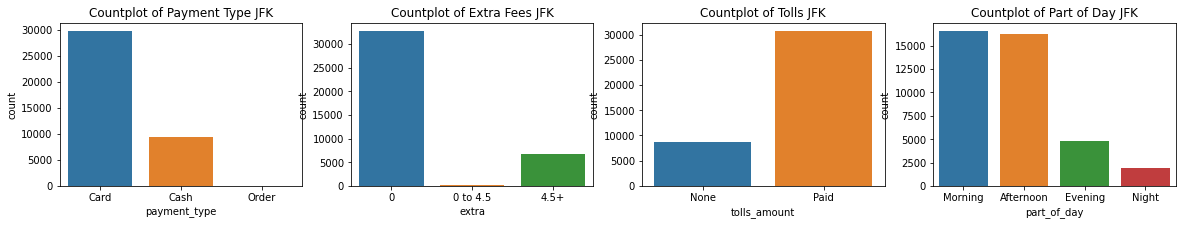

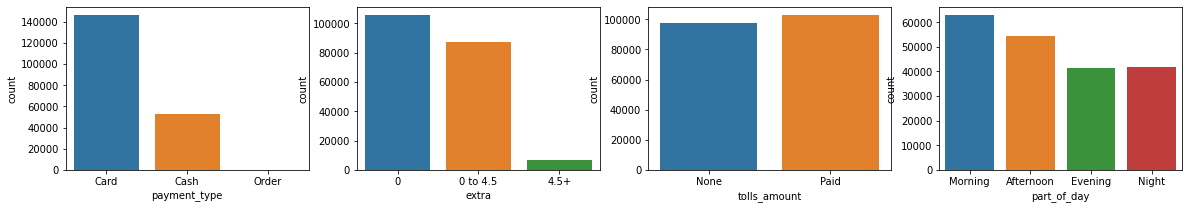

In [ ]:
#Plotting the characteristics of JFK Airport
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(20, 3))
sns.countplot(x = df_final_pred[df_final_pred.Zone_dropoff == 'JFK Airport']['payment_type'], ax=ax1, order = ['Card','Cash','Order'])
ax1.set_title("Countplot of Payment Type JFK")
sns.countplot(x = df_final_pred[df_final_pred.Zone_dropoff == 'JFK Airport']['extra'], ax=ax2, order = ['0','0 to 4.5','4.5+'])
ax2.set_title("Countplot of Extra Fees JFK")
sns.countplot(x = df_final_pred[df_final_pred.Zone_dropoff == 'JFK Airport']['tolls_amount'], ax=ax3, order = ['None', 'Paid'])
ax3.set_title("Countplot of Tolls JFK")
sns.countplot(x = df_final_pred[df_final_pred.Zone_dropoff == 'JFK Airport']['part_of_day'], ax=ax4, order = ['Morning','Afternoon','Evening','Night'])
ax4.set_title("Countplot of Part of Day JFK")

#Plotting the characteristics of Queens
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(20, 3))
sns.countplot(x = df_final_pred[df_final_pred.Queens == 1]['payment_type'], ax=ax1, order = ['Card','Cash','Order'])
sns.countplot(x = df_final_pred[df_final_pred.Queens == 1]['extra'], ax=ax2, order = ['0','0 to 4.5','4.5+'])
sns.countplot(x = df_final_pred[df_final_pred.Queens == 1]['tolls_amount'],ax=ax3, order = ['None', 'Paid'])
sns.countplot(x = df_final_pred[df_final_pred.Queens == 1]['part_of_day'],ax=ax4, order = ['Morning','Afternoon','Evening','Night'])

#Properties of our Incorrectly Classified Regions 

*   Properties of incorrectly classified Queens
  *  Shorter **trip_distance** (5.7m vs 12.5m)
  *  Mostly did not have **Tolls**
  *  Picked up at the latter half of the **day**



*   Properties of incorrectly classified Brooklyn
  * Longer **trip_distance** (9.6m vs 5.7m)
  * Half of these rides have **Tolls** 
  * Picked up at the first half of the **day**

In [ ]:
#Comparing incorrect and correct classification
df_final_pred.groupby(['Queens','Correct'])[['trip_distance', 'tip_amount','Probability','Correct']].mean()

trip_distance  tip_amount  Probability  Correct
Queens Correct                                                 
0      False         9.572364    3.470421     0.648977    False
       True          5.672398    3.103604     0.329687     True
1      False         5.689542    2.550379     0.350948    False
       True         12.528002    6.110951     0.805095     True

Text(0.5, 1.0, 'Countplot of Part of Day Queens Incorrect')

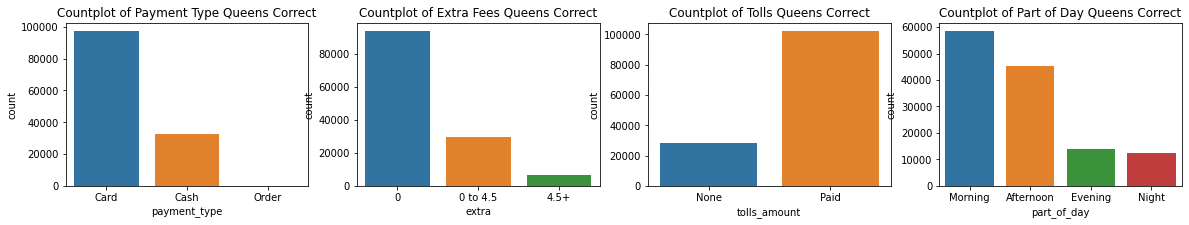

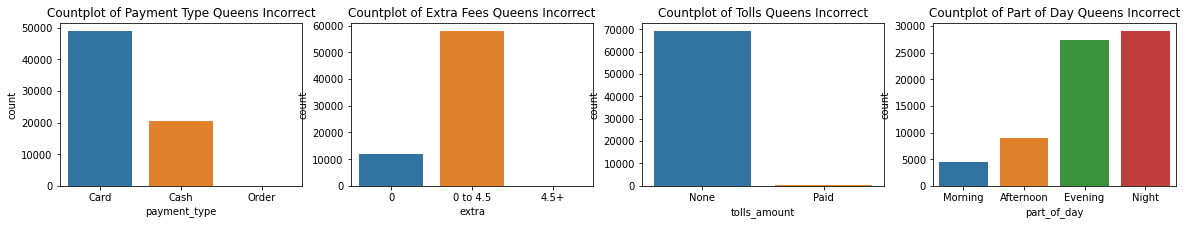

In [ ]:
#Plotting the characteristics of Queens Correct
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(20, 3))
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 1) & (df_final_pred.Correct == True)]['payment_type'], ax=ax1, order = ['Card','Cash','Order'])
ax1.set_title("Countplot of Payment Type Queens Correct")
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 1) & (df_final_pred.Correct == True)]['extra'], ax=ax2, order = ['0','0 to 4.5','4.5+'])
ax2.set_title("Countplot of Extra Fees Queens Correct")
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 1) & (df_final_pred.Correct == True)]['tolls_amount'],ax=ax3, order = ['None', 'Paid'])
ax3.set_title("Countplot of Tolls Queens Correct")
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 1) & (df_final_pred.Correct == True)]['part_of_day'],ax=ax4, order = ['Morning','Afternoon','Evening','Night'])
ax4.set_title("Countplot of Part of Day Queens Correct")

#Plotting the characteristics of Queens Incorrect
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(20, 3))
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 1) & (df_final_pred.Correct == False)]['payment_type'], ax=ax1, order = ['Card','Cash','Order'])
ax1.set_title("Countplot of Payment Type Queens Incorrect")
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 1) & (df_final_pred.Correct == False)]['extra'], ax=ax2, order = ['0','0 to 4.5','4.5+'])
ax2.set_title("Countplot of Extra Fees Queens Incorrect")
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 1) & (df_final_pred.Correct == False)]['tolls_amount'],ax=ax3, order = ['None', 'Paid'])
ax3.set_title("Countplot of Tolls Queens Incorrect")
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 1) & (df_final_pred.Correct == False)]['part_of_day'],ax=ax4, order = ['Morning','Afternoon','Evening','Night'])
ax4.set_title("Countplot of Part of Day Queens Incorrect")

Text(0.5, 1.0, 'Countplot of Part of Day Brooklyn Incorrect')

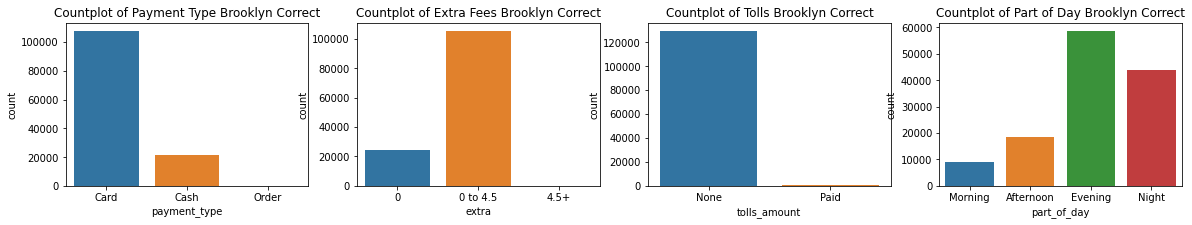

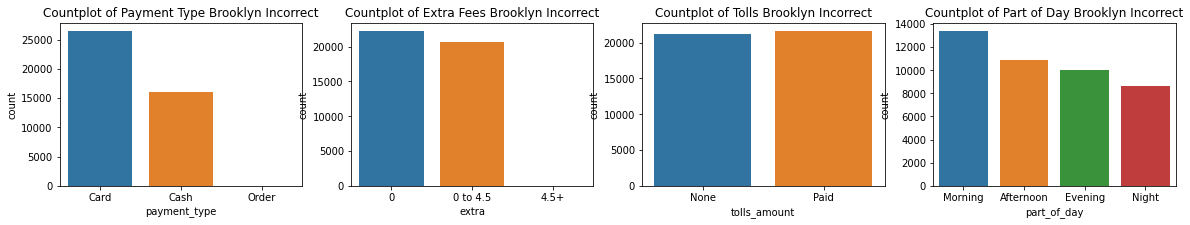

In [ ]:
#Plotting the characteristics of Brooklyn Correct
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(20, 3))
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 0) & (df_final_pred.Correct == True)]['payment_type'], ax=ax1, order = ['Card','Cash','Order'])
ax1.set_title("Countplot of Payment Type Brooklyn Correct")
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 0) & (df_final_pred.Correct == True)]['extra'], ax=ax2, order = ['0','0 to 4.5','4.5+'])
ax2.set_title("Countplot of Extra Fees Brooklyn Correct")
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 0) & (df_final_pred.Correct == True)]['tolls_amount'],ax=ax3, order = ['None', 'Paid'])
ax3.set_title("Countplot of Tolls Brooklyn Correct")
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 0) & (df_final_pred.Correct == True)]['part_of_day'],ax=ax4, order = ['Morning','Afternoon','Evening','Night'])
ax4.set_title("Countplot of Part of Day Brooklyn Correct")

#Plotting the characteristics of Brooklyn Incorrect
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(20, 3))
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 0) & (df_final_pred.Correct == False)]['payment_type'], ax=ax1, order = ['Card','Cash','Order'])
ax1.set_title("Countplot of Payment Type Brooklyn Incorrect")
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 0) & (df_final_pred.Correct == False)]['extra'], ax=ax2, order = ['0','0 to 4.5','4.5+'])
ax2.set_title("Countplot of Extra Fees Brooklyn Incorrect")
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 0) & (df_final_pred.Correct == False)]['tolls_amount'],ax=ax3, order = ['None', 'Paid'])
ax3.set_title("Countplot of Tolls Brooklyn Incorrect")
sns.countplot(x = df_final_pred[(df_final_pred.Queens == 0) & (df_final_pred.Correct == False)]['part_of_day'],ax=ax4, order = ['Morning','Afternoon','Evening','Night'])
ax4.set_title("Countplot of Part of Day Brooklyn Incorrect")

#Retraining the Model


*   Rethink **tip_amount**
  * **Tip_amount** as is seems unlikely to inform beyond **trip_distance** and may cause model interpretation difficulty due to collinearity.
  * Using **fare_amount** to create a **tip_percent** feature would divorce tip from distance while still measuring tip relativity.
*   Explore including interaction terms
  * In interest of simplicity, I did not include interaction terms but we know from our grouped barplots that there exist relationships.
  * Interactions enable our model to capture more complicated patterns and lead to classifications with more nuanced logic
  * For example, **extra** is related to **part_of_day** given that the fee structure involves time-based charges like overnight or rush hour fees.
  * Interactions could especially be beneficial for zones like *Maspeth* which currently receive mixed signals for classification.
* Feature engineering
  * Investigating the incorrectly classified regions demonstrate that our selected features are currently insufficient for certain areas.
  * We may also be interested in revisiting variables like **pickup** and seeing if creating **weekday** information would be valuable.


#Summary


*   We were able to create a logistic regression model that classifies with **70% accuracy**, **75% precision**, and **65% recall**
*   Prior information was leveraged from the data dictionary and our coefficient directions match our findings from Exploratory Data Analysis. 
* A strength of the model is its interpretation simplicity but it would also likely benefit from including more complex terms.
* Our strongest predictors are the payment of a **toll** or high **extra** fees but we may want to temper their effects with interaction terms. 
* Our model is weaker for the parts of *Queens* closer to Manhattan that do not involve a bridge with toll and the reverse for *Brooklyn*. 
* Next steps involve investigating properties of such areas to uncover patterns that we may be able to improve model with.
* Also worthwhile to experiment with other classifiers if certain areas are too difficult to separate well with linear decision boundaries.